Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# 3D Multi-organ Segmentation with UNETR  (BTCV Challenge)


This tutorial demonstrates how to construct a training workflow of UNETR [1] on multi-organ segmentation task using the BTCV challenge dataset.
![image](https://lh3.googleusercontent.com/pw/AM-JKLU2eTW17rYtCmiZP3WWC-U1HCPOHwLe6pxOfJXwv2W-00aHfsNy7jeGV1dwUq0PXFOtkqasQ2Vyhcu6xkKsPzy3wx7O6yGOTJ7ZzA01S6LSh8szbjNLfpbuGgMe6ClpiS61KGvqu71xXFnNcyvJNFjN=w1448-h496-no?authuser=0)

And it contains the following features:
1. Transforms for dictionary format data.
1. Define a new transform according to MONAI transform API.
1. Load Nifti image with metadata, load a list of images and stack them.
1. Randomly adjust intensity for data augmentation.
1. Cache IO and transforms to accelerate training and validation.
1. 3D UNETR model, DiceCE loss function, Mean Dice metric for multi-organ segmentation task.

The dataset comes from https://www.synapse.org/#!Synapse:syn3193805/wiki/217752.  

Under Institutional Review Board (IRB) supervision, 50 abdomen CT scans of were randomly selected from a combination of an ongoing colorectal cancer chemotherapy trial, and a retrospective ventral hernia study. The 50 scans were captured during portal venous contrast phase with variable volume sizes (512 x 512 x 85 - 512 x 512 x 198) and field of views (approx. 280 x 280 x 280 mm3 - 500 x 500 x 650 mm3). The in-plane resolution varies from 0.54 x 0.54 mm2 to 0.98 x 0.98 mm2, while the slice thickness ranges from 2.5 mm to 5.0 mm.

Target: 13 abdominal organs including 1. Spleen 2. Right Kidney 3. Left Kidney 4.Gallbladder 5.Esophagus 6. Liver 7. Stomach 8.Aorta 9. IVC 10. Portal and Splenic Veins 11. Pancreas 12 Right adrenal gland 13 Left adrenal gland.

Modality: CT
Size: 30 3D volumes (24 Training + 6 Testing)  
Challenge: BTCV MICCAI Challenge

The following figure shows image patches with the organ sub-regions that are annotated in the CT (top left) and the final labels for the whole dataset (right).

Data, figures and resources are taken from:


1. [UNETR: Transformers for 3D Medical Image Segmentation](https://arxiv.org/abs/2103.10504)

2. [High-resolution 3D abdominal segmentation with random patch network fusion (MIA)](https://www.sciencedirect.com/science/article/abs/pii/S1361841520302589)

3. [Efficient multi-atlas abdominal segmentation on clinically acquired CT with SIMPLE context learning (MIA)](https://www.sciencedirect.com/science/article/abs/pii/S1361841515000766?via%3Dihub)


![image](https://lh3.googleusercontent.com/pw/AM-JKLX0svvlMdcrchGAgiWWNkg40lgXYjSHsAAuRc5Frakmz2pWzSzf87JQCRgYpqFR0qAjJWPzMQLc_mmvzNjfF9QWl_1OHZ8j4c9qrbR6zQaDJWaCLArRFh0uPvk97qAa11HtYbD6HpJ-wwTCUsaPcYvM=w1724-h522-no?authuser=0)



The image patches show anatomies of a subject, including:
1. large organs: spleen, liver, stomach.
2. Smaller organs: gallbladder, esophagus, kidneys, pancreas.
3. Vascular tissues: aorta, IVC, P&S Veins.
4. Glands: left and right adrenal gland

If you find this tutorial helpful, please consider citing [1]:

[1]: Hatamizadeh, A., Tang, Y., Nath, V., Yang, D., Myronenko, A., Landman, B., Roth, H.R. and Xu, D., 2022. Unetr: Transformers for 3d medical image segmentation. In Proceedings of the IEEE/CVF Winter Conference on Applications of Computer Vision (pp. 574-584).

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/main/3d_segmentation/unetr_btcv_segmentation_3d.ipynb)

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

## Setup environment

In [2]:
# !pip install -q "monai-weekly[nibabel, tqdm, einops]"
# !python -c "import matplotlib" || pip install -q matplotlib
#%matplotlib inline

In [3]:
# !jupyter nbextension enable --py widgetsnbextension

## Setup imports

In [4]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
from tqdm import tqdm
from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
)
from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import UNETR, UNet, DynUNet, SegResNet
from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)
import torch
from torch.autograd import Variable
import pandas as pd

In [5]:
print_config()

MONAI version: 1.4.dev2349
Numpy version: 1.26.2
Pytorch version: 1.13.0+cu116
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 33a84c61010bddf1a458431ec7c01d9ecdabbcc2
MONAI __file__: /home/<username>/.local/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.1.0
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
scipy version: 1.11.3
Pillow version: 9.0.1
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.14.0+cu116
tqdm version: 4.65.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 6.0.0
pandas version: 2.1.3
einops version: 0.7.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INS

## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [6]:
# directory = os.environ.get("MONAI_DATA_DIRECTORY")
directory = 'models'
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

models


In [7]:
directory

'models'

## Setup transforms for training and validation

In [8]:
import torch.nn.functional as F

In [9]:
# Function to pad images and labels
def pad_images(data):
    data["image"] = F.pad(data["image"], (3, 3, 8, 8, 15, 15), "constant", 0)  # Padding for image
    data["label"] = F.pad(data["label"], (3, 3, 8, 8, 15, 15), "constant", 0)  # Padding for label
    return data

train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-175,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        pad_images,
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 16),
            pos=1,
            neg=0.1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["image", "label"], source_key="image"),
    ]
)

### My transforms
test_transforms = Compose(
    [
        LoadImaged(keys=["image"]),
        EnsureChannelFirstd(keys=["image"]),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(
            keys=["image"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear"),
        ),
        ScaleIntensityRanged(keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["image"], source_key="image"),
    ]
)



/home/jruizmunoz/.local/lib/python3.10/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


 ## Download dataset and format in the folder.
    1. Download dataset from here: https://www.synapse.org/#!Synapse:syn3193805/wiki/89480\n
    2. Put images in the ./data/imagesTr
    3. Put labels in the ./data/labelsTr
    4. make JSON file accordingly: ./data/dataset_0.json
    

In [10]:
# rootpath = "drive/MyDrive/datasets"
# rootpath = "D:\monailabel\datasets"
# rootpath = "E:\monailabel\datasets"
rootpath = os.path.join("..","datasets")
# os.listdir(os.path.join(rootpath,"Task09_Spleen"))
os.listdir(os.path.join(rootpath,"soilcores"))

['dataset_0.json',
 'test',
 'datastore_v2.json',
 'training',
 '.ipynb_checkpoints',
 'dataset_2.json',
 'dataset_1.json']

In [11]:
net_type = 'UNet' # network architecture: UNet, UNETR, DynUNet, or SegResNet
net_type = net_type.lower()

In [12]:
# data_dir = os.path.join(rootpath,"Task09_Spleen") # "/dataset/"
data_dir = os.path.join(rootpath,"soilcores")
split_json = "dataset_2.json" # "dataset_0.json"
max_iter_training = 10000
model_name = net_type+"_"+split_json[:-5]+"_"+'10k'

datasets = os.path.join(data_dir, split_json)
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
test_files = load_decathlon_datalist(datasets, True, "test")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,
    cache_rate=1.0,
    num_workers=1,
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=1, pin_memory=True)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=1)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=1, pin_memory=True)

test_ds = CacheDataset(data=test_files, transform=test_transforms, cache_num=6, cache_rate=1.0, num_workers=1)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=1, pin_memory=True)

Loading dataset: 100%|██████████| 6/6 [00:06<00:00,  1.14s/it]


## Check data shape and visualize

image shape: torch.Size([1, 116, 109, 10]), label shape: torch.Size([1, 116, 109, 10])


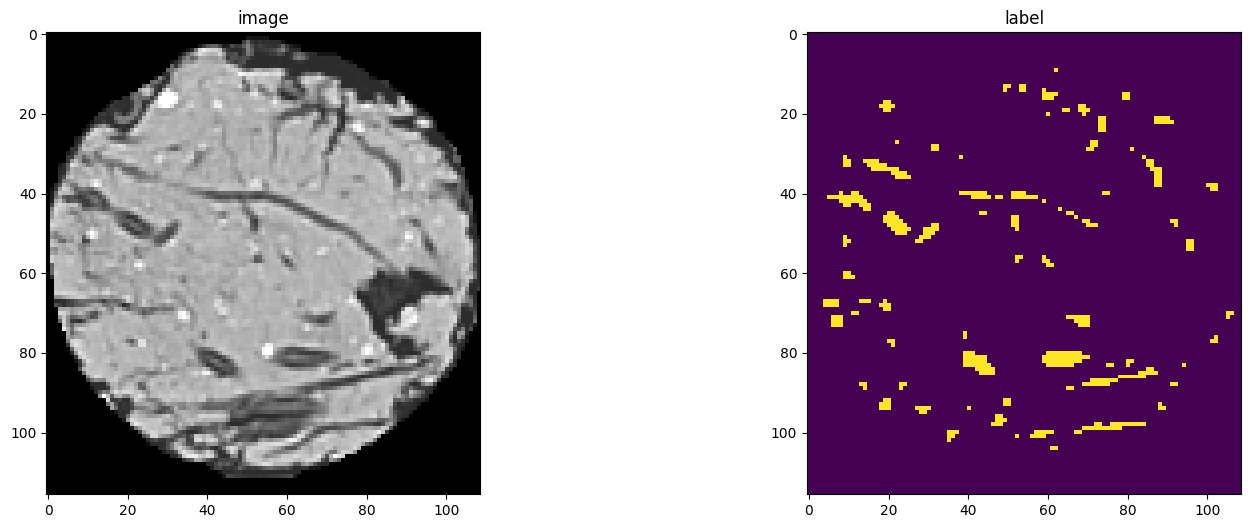

In [13]:
# slice_map = {
#     "spleen_33.nii.gz": 170,
#     "spleen_38.nii.gz": 230,
#     "spleen_40.nii.gz": 204,
#     "spleen_41.nii.gz": 204,
#     "spleen_44.nii.gz": 204,
#     "spleen_45.nii.gz": 180,
# }

# slice_map = {
#     "S1919_small1.nii.gz": 5,
#     "S2307_small1.nii.gz": 5,
#     "S2403_small3.nii.gz": 5,
#     "S3117_small1.nii.gz": 5,
# }

slice_map = {
    "C5608_small1.nii.gz": 5
}

case_num = 3
img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
img = val_ds[case_num]["image"]
label = val_ds[case_num]["label"]
img_shape = img.shape
label_shape = label.shape
print(f"image shape: {img_shape}, label shape: {label_shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[0, :, :, slice_map[img_name]].detach().cpu(), cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0, :, :, slice_map[img_name]].detach().cpu())
plt.show()

image shape: torch.Size([1, 114, 114, 507])


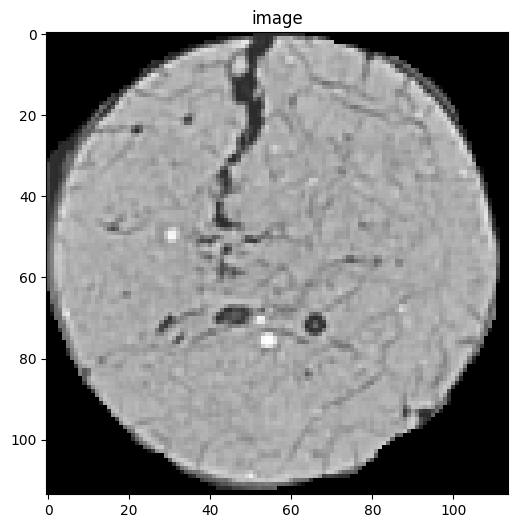

In [14]:
slice_map = {
    "C1216.nii.gz": 50,
    "C2003.nii.gz": 50,
    "C2609.nii.gz": 50,
    "C2803.nii.gz": 50,
}

case_num = 3
img_name = os.path.split(test_ds[case_num]["image"].meta["filename_or_obj"])[1]
img = test_ds[case_num]["image"]
img_shape = img.shape
print(f"image shape: {img_shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[0, :, :, slice_map[img_name]].detach().cpu(), cmap="gray")
plt.show()

### Create Model, Loss, Optimizer


In [15]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# network architecture: unet, unetr, dynunet, or segresnet
if net_type == 'unet':
    class UNetWithSigmoid(UNet):
        def forward(self, x):
            x = super().forward(x)
            x = torch.sigmoid(x)
            return x

    # Initialize the UNet model with sigmoid
    model = UNetWithSigmoid(
        spatial_dims=3,  # Use `spatial_dims` instead of `dimensions`
        in_channels=1,
        out_channels=1,  # For binary segmentation
        channels=(16, 32, 64, 128, 256),  # Filters at each level
        strides=(2, 2, 2, 2),  # Downsampling factors
        num_res_units=2,  # Number of residual units
        norm='instance',  # Use instance normalization
    ).to(device)

elif net_type == 'unetr':
    class UNETRWithSigmoid(UNETR):
        def forward(self, x):
            x = super().forward(x)
            x = torch.sigmoid(x)
            return x

    model = UNETRWithSigmoid(
        in_channels=1,
        out_channels=1,
        img_size=(96, 96, 16),
        feature_size=16,
        hidden_size=768,
        mlp_dim= 3072, 
        num_heads=12, # default 12
        pos_embed="perceptron",
        norm_name="instance",
        res_block=True,
        dropout_rate=0.2,
    ).to(device)
    
elif net_type == 'dynunet':
    class DynUNetWithSigmoid(DynUNet):
        def forward(self, x):
            x = super().forward(x)
            x = torch.sigmoid(x)
            return x

    # Initialize the DynUNet model with sigmoid
    model = DynUNetWithSigmoid(
        spatial_dims=3,
        in_channels=1,
        out_channels=1,
        kernel_size=[3, 3, 3, 3, 3],
        strides=[1, 2, 2, 2, 2],
        upsample_kernel_size=[2, 2, 2, 2],
        filters=(16, 32, 64, 128, 256),
        norm_name="instance",
    ).to(device)
    
elif net_type == 'segresnet':
    class SegResNetWithSigmoid(SegResNet):
        def forward(self, x):
            x = super().forward(x)
            x = torch.sigmoid(x)
            return x

    # Initialize the SegResNet model with sigmoid
    model = SegResNetWithSigmoid(
        spatial_dims=3,
        in_channels=1,
        out_channels=1,
        init_filters=16,
        blocks_down=[1, 2, 2, 4],
        blocks_up=[1, 1, 1],
        norm="instance",
    ).to(device)
    
else:
    assert False, "Selected network does not exist"
    

# Define the loss function without sigmoid as it's already applied in the model
loss_function = DiceCELoss(to_onehot_y=False, sigmoid=False)
    
# img_size=(96, 96, 96),
# model = UNETR(
#     in_channels=1,
#     out_channels=1,
#     img_size=(96, 96, 16),
#     feature_size=16,
#     hidden_size=768,
#     mlp_dim= 3072,
#     num_heads=12,
#     pos_embed="perceptron",
#     norm_name="instance",
#     res_block=True,
#     dropout_rate=0.2,
# ).to(device)
# loss_function = DiceCELoss(to_onehot_y=False, sigmoid=True)
torch.backends.cudnn.benchmark = True

In [16]:
# Save initial model
# torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))

In [17]:
# optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-3) # , weight_decay=1e-5
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-2, weight_decay=1e-6)

### Execute a typical PyTorch training process

In [18]:
# def validation(epoch_iterator_val):
#     model.eval()
#     with torch.no_grad():
#         for batch in epoch_iterator_val:
#             val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
#             # val_inputs, val_labels = (batch["image"], batch["label"])
#             val_labels = val_labels/2.
#             val_outputs = sliding_window_inference(val_inputs, (96, 96, 16), 4, model)
#             # val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
#             # val_outputs = sliding_window_inference(val_inputs.to('cpu'), (96, 96, 96), 4, model.to('cpu'))
#             val_labels_list = decollate_batch(val_labels)
#             val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
#             val_outputs_list = decollate_batch(val_outputs)
#             val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
#             dice_metric(y_pred=val_output_convert, y=val_labels_convert)
#             epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
#         mean_dice_val = dice_metric.aggregate().item()
#         dice_metric.reset()
#     return mean_dice_val


# def train(global_step, train_loader, dice_val_best, global_step_best):
#     model.train()
#     epoch_loss = 0
#     step = 0
#     epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
#     for step, batch in enumerate(epoch_iterator):
#         step += 1
#         x, y = (batch["image"].cuda(), batch["label"].cuda())
#         y = y/2.
#         zz = torch.zeros(x.size(0),x.size(1),x.size(2),x.size(3),96-x.size(4)).to(torch.float32).to(device)
#         x = torch.cat((x,zz),dim=4)
#         y = torch.cat((y,zz),dim=4)
#         logit_map = model(x)
#         loss = loss_function(logit_map, y)
#         loss.backward()
#         epoch_loss += loss.item()
#         optimizer.step()
#         optimizer.zero_grad()
#         epoch_iterator.set_description("Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss))
#         if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
#             epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
#             dice_val = validation(epoch_iterator_val)
#             epoch_loss /= step
#             epoch_indx.append(step)
#             epoch_loss_values.append(epoch_loss)
#             metric_values.append(dice_val)
            
#             dic_perf = {
#                 'epochs': epoch_indx,
#                 'dice_loss': epoch_loss_values,
#                 'dice_metric': metric_values 
#             }

#             df = pd.DataFrame(dic_perf)
#             df.to_csv('results.csv',index=False)
            
#             if dice_val > dice_val_best:
#                 dice_val_best = dice_val
#                 global_step_best = global_step
#                 torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model"+model_name+".pth"))
#                 print(
#                     "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
#                 )
#             else:
#                 print(
#                     "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
#                         dice_val_best, dice_val
#                     )
#                 )
#         global_step += 1
#     return global_step, dice_val_best, global_step_best


# max_iterations = 5000 # 25000
# eval_num = 100
# post_label = AsDiscrete(threshold=0.5) # AsDiscrete(to_onehot=1) This threshold shouldn't be 0.0
# post_pred = AsDiscrete(threshold=0.0) # AsDiscrete(argmax=True, to_onehot=1)
# dice_metric = DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
# global_step = 0
# dice_val_best = 0.0
# global_step_best = 0
# epoch_loss_values = []
# metric_values = []
# epoch_indx = []
# try:
#     model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model"+model_name+".pth")))
# except:
#     print("Pre-trained model not found!")
# while global_step < max_iterations:
#     global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
# model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model"+model_name+".pth")))

In [19]:
# Validation function
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 16), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val

# Training function
def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        # Pad x and y to (128, 128, 16)
        zz_x = torch.zeros(x.size(0), x.size(1), x.size(2), x.size(3), 16 - x.size(4)).to(torch.float32).to(device)
        zz_y = torch.zeros(y.size(0), y.size(1), y.size(2), y.size(3), 16 - y.size(4)).to(torch.float32).to(device)
        x = torch.cat((x, zz_x), dim=4)
        y = torch.cat((y, zz_y), dim=4)
        
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description("Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss))
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_indx.append(step)
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            
            dic_perf = {
                'epochs': epoch_indx,
                'dice_loss': epoch_loss_values,
                'dice_metric': metric_values 
            }

            df = pd.DataFrame(dic_perf)
            df.to_csv('results.csv', index=False)
            
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model" + model_name + ".pth"))
                print("Model Was Saved! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val))
            else:
                print("Model Was Not Saved! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val))
        global_step += 1
    return global_step, dice_val_best, global_step_best

# Initialize variables
max_iterations = max_iter_training # default: 10000
eval_num = 100
post_label = AsDiscrete(threshold=0.5)
post_pred = AsDiscrete(threshold=0.5)
dice_metric = DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
epoch_indx = []

# Load pre-trained model if available
try:
    model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model" + model_name + ".pth")))
except:
    print("Pre-trained model not found!")

# Training loop
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)

# Load the best model
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model" + model_name + ".pth")))

Pre-trained model not found!


Training (102 / 10000 Steps) (loss=1.61690):  36%|███▌      | 5/14 [00:01<00:02,  3.23it/s]

Model Was Saved! Current Best Avg. Dice: 0.21057741343975067 Current Avg. Dice: 0.21057741343975067


Training (202 / 10000 Steps) (loss=1.30554):  50%|█████     | 7/14 [00:01<00:01,  3.76it/s]

Model Was Saved! Current Best Avg. Dice: 0.34497785568237305 Current Avg. Dice: 0.34497785568237305


Training (302 / 10000 Steps) (loss=1.00216):  64%|██████▍   | 9/14 [00:01<00:01,  4.25it/s]

Model Was Saved! Current Best Avg. Dice: 0.3961234986782074 Current Avg. Dice: 0.3961234986782074


Training (402 / 10000 Steps) (loss=1.31682):  79%|███████▊  | 11/14 [00:02<00:00,  4.42it/s]

Model Was Saved! Current Best Avg. Dice: 0.4360906183719635 Current Avg. Dice: 0.4360906183719635


Training (503 / 10000 Steps) (loss=1.33968):  93%|█████████▎| 13/14 [00:02<00:00,  4.74it/s]

Model Was Not Saved! Current Best Avg. Dice: 0.4360906183719635 Current Avg. Dice: 0.43124035000801086


Training (601 / 10000 Steps) (loss=0.97762): 100%|██████████| 14/14 [00:02<00:00,  5.76it/s]


Model Was Saved! Current Best Avg. Dice: 0.45476168394088745 Current Avg. Dice: 0.45476168394088745


Training (702 / 10000 Steps) (loss=0.86930):  21%|██▏       | 3/14 [00:01<00:04,  2.51it/s]

Model Was Saved! Current Best Avg. Dice: 0.4743650555610657 Current Avg. Dice: 0.4743650555610657


Training (802 / 10000 Steps) (loss=0.85734):  36%|███▌      | 5/14 [00:01<00:02,  3.30it/s]

Model Was Saved! Current Best Avg. Dice: 0.48697444796562195 Current Avg. Dice: 0.48697444796562195


Training (902 / 10000 Steps) (loss=0.98787):  50%|█████     | 7/14 [00:01<00:01,  3.91it/s]

Model Was Saved! Current Best Avg. Dice: 0.5053630471229553 Current Avg. Dice: 0.5053630471229553


Training (1003 / 10000 Steps) (loss=0.83471):  64%|██████▍   | 9/14 [00:02<00:01,  4.31it/s]

Model Was Not Saved! Current Best Avg. Dice: 0.5053630471229553 Current Avg. Dice: 0.5007718801498413


Training (1102 / 10000 Steps) (loss=1.03842):  79%|███████▊  | 11/14 [00:02<00:00,  4.42it/s]

Model Was Saved! Current Best Avg. Dice: 0.5135256052017212 Current Avg. Dice: 0.5135256052017212


Training (1203 / 10000 Steps) (loss=1.01528):  93%|█████████▎| 13/14 [00:02<00:00,  4.64it/s]

Model Was Saved! Current Best Avg. Dice: 0.5276561379432678 Current Avg. Dice: 0.5276561379432678


Training (1301 / 10000 Steps) (loss=0.81512): 100%|██████████| 14/14 [00:02<00:00,  5.87it/s]


Model Was Not Saved! Current Best Avg. Dice: 0.5276561379432678 Current Avg. Dice: 0.5236616730690002


Training (1402 / 10000 Steps) (loss=0.81203):  21%|██▏       | 3/14 [00:01<00:04,  2.48it/s]

Model Was Saved! Current Best Avg. Dice: 0.5475615859031677 Current Avg. Dice: 0.5475615859031677


Training (1502 / 10000 Steps) (loss=1.00345):  36%|███▌      | 5/14 [00:01<00:02,  3.35it/s]

Model Was Saved! Current Best Avg. Dice: 0.5592406988143921 Current Avg. Dice: 0.5592406988143921


Training (1602 / 10000 Steps) (loss=0.81861):  50%|█████     | 7/14 [00:01<00:01,  3.99it/s]

Model Was Not Saved! Current Best Avg. Dice: 0.5592406988143921 Current Avg. Dice: 0.5515058636665344


Training (1703 / 10000 Steps) (loss=1.05450):  64%|██████▍   | 9/14 [00:02<00:01,  4.33it/s]

Model Was Not Saved! Current Best Avg. Dice: 0.5592406988143921 Current Avg. Dice: 0.5502151846885681


Training (1802 / 10000 Steps) (loss=0.94847):  79%|███████▊  | 11/14 [00:02<00:00,  4.54it/s]

Model Was Not Saved! Current Best Avg. Dice: 0.5592406988143921 Current Avg. Dice: 0.5556398034095764


Training (1903 / 10000 Steps) (loss=0.93091):  93%|█████████▎| 13/14 [00:02<00:00,  4.76it/s]

Model Was Not Saved! Current Best Avg. Dice: 0.5592406988143921 Current Avg. Dice: 0.5539496541023254


Training (2001 / 10000 Steps) (loss=0.89235): 100%|██████████| 14/14 [00:02<00:00,  5.79it/s]


Model Was Saved! Current Best Avg. Dice: 0.5837740898132324 Current Avg. Dice: 0.5837740898132324


Training (2102 / 10000 Steps) (loss=0.73117):  21%|██▏       | 3/14 [00:01<00:05,  2.08it/s]

Model Was Saved! Current Best Avg. Dice: 0.5852231979370117 Current Avg. Dice: 0.5852231979370117


Training (2202 / 10000 Steps) (loss=0.75892):  36%|███▌      | 5/14 [00:01<00:02,  3.46it/s]

Model Was Not Saved! Current Best Avg. Dice: 0.5852231979370117 Current Avg. Dice: 0.5761553645133972


Training (2302 / 10000 Steps) (loss=0.73597):  50%|█████     | 7/14 [00:01<00:01,  3.89it/s]

Model Was Saved! Current Best Avg. Dice: 0.5859273672103882 Current Avg. Dice: 0.5859273672103882


Training (2402 / 10000 Steps) (loss=0.86755):  64%|██████▍   | 9/14 [00:02<00:01,  4.19it/s]

Model Was Saved! Current Best Avg. Dice: 0.5991508364677429 Current Avg. Dice: 0.5991508364677429


Training (2502 / 10000 Steps) (loss=0.78322):  79%|███████▊  | 11/14 [00:02<00:00,  4.44it/s]

Model Was Saved! Current Best Avg. Dice: 0.6059079170227051 Current Avg. Dice: 0.6059079170227051


Training (2603 / 10000 Steps) (loss=0.85119):  93%|█████████▎| 13/14 [00:02<00:00,  4.67it/s]

Model Was Saved! Current Best Avg. Dice: 0.6102839112281799 Current Avg. Dice: 0.6102839112281799


Training (2701 / 10000 Steps) (loss=0.73133): 100%|██████████| 14/14 [00:02<00:00,  5.75it/s]


Model Was Saved! Current Best Avg. Dice: 0.6152065992355347 Current Avg. Dice: 0.6152065992355347


Training (2802 / 10000 Steps) (loss=0.73996):  21%|██▏       | 3/14 [00:01<00:04,  2.57it/s]

Model Was Not Saved! Current Best Avg. Dice: 0.6152065992355347 Current Avg. Dice: 0.6047207713127136


Training (2902 / 10000 Steps) (loss=0.73476):  36%|███▌      | 5/14 [00:01<00:02,  3.38it/s]

Model Was Not Saved! Current Best Avg. Dice: 0.6152065992355347 Current Avg. Dice: 0.6115390062332153


Training (3003 / 10000 Steps) (loss=0.92166):  50%|█████     | 7/14 [00:01<00:01,  3.70it/s]

Model Was Not Saved! Current Best Avg. Dice: 0.6152065992355347 Current Avg. Dice: 0.6101378202438354


Training (3102 / 10000 Steps) (loss=0.81145):  64%|██████▍   | 9/14 [00:02<00:01,  4.21it/s]

Model Was Saved! Current Best Avg. Dice: 0.628747284412384 Current Avg. Dice: 0.628747284412384


Training (3202 / 10000 Steps) (loss=0.75895):  79%|███████▊  | 11/14 [00:02<00:00,  4.51it/s]

Model Was Not Saved! Current Best Avg. Dice: 0.628747284412384 Current Avg. Dice: 0.5875188708305359


Training (3303 / 10000 Steps) (loss=1.23956):  93%|█████████▎| 13/14 [00:02<00:00,  4.71it/s]

Model Was Not Saved! Current Best Avg. Dice: 0.628747284412384 Current Avg. Dice: 0.6086761355400085


Training (3401 / 10000 Steps) (loss=0.77611): 100%|██████████| 14/14 [00:02<00:00,  5.71it/s]


Model Was Saved! Current Best Avg. Dice: 0.6408405303955078 Current Avg. Dice: 0.6408405303955078


Training (3503 / 10000 Steps) (loss=0.68509):  21%|██▏       | 3/14 [00:01<00:04,  2.58it/s]

Model Was Not Saved! Current Best Avg. Dice: 0.6408405303955078 Current Avg. Dice: 0.622121274471283


Training (3602 / 10000 Steps) (loss=0.72963):  36%|███▌      | 5/14 [00:01<00:02,  3.14it/s]

Model Was Saved! Current Best Avg. Dice: 0.6421380043029785 Current Avg. Dice: 0.6421380043029785


Training (3702 / 10000 Steps) (loss=0.90405):  50%|█████     | 7/14 [00:01<00:01,  3.88it/s]

Model Was Saved! Current Best Avg. Dice: 0.6429106593132019 Current Avg. Dice: 0.6429106593132019


Training (3803 / 10000 Steps) (loss=0.97878):  64%|██████▍   | 9/14 [00:02<00:01,  4.31it/s]

Model Was Not Saved! Current Best Avg. Dice: 0.6429106593132019 Current Avg. Dice: 0.6334654688835144


Training (3903 / 10000 Steps) (loss=1.22865):  79%|███████▊  | 11/14 [00:02<00:00,  3.93it/s]

Model Was Not Saved! Current Best Avg. Dice: 0.6429106593132019 Current Avg. Dice: 0.6316853761672974


Training (4003 / 10000 Steps) (loss=0.83761):  93%|█████████▎| 13/14 [00:02<00:00,  4.66it/s]

Model Was Saved! Current Best Avg. Dice: 0.6440576910972595 Current Avg. Dice: 0.6440576910972595


Training (4101 / 10000 Steps) (loss=0.76630): 100%|██████████| 14/14 [00:02<00:00,  5.88it/s]


Model Was Not Saved! Current Best Avg. Dice: 0.6440576910972595 Current Avg. Dice: 0.6378306746482849


Training (4202 / 10000 Steps) (loss=0.94122):  21%|██▏       | 3/14 [00:01<00:04,  2.49it/s]

Model Was Saved! Current Best Avg. Dice: 0.6682018041610718 Current Avg. Dice: 0.6682018041610718


Training (4303 / 10000 Steps) (loss=0.85705):  36%|███▌      | 5/14 [00:01<00:02,  3.44it/s]

Model Was Not Saved! Current Best Avg. Dice: 0.6682018041610718 Current Avg. Dice: 0.6646846532821655


Training (4403 / 10000 Steps) (loss=0.75546):  50%|█████     | 7/14 [00:01<00:01,  3.98it/s]

Model Was Not Saved! Current Best Avg. Dice: 0.6682018041610718 Current Avg. Dice: 0.6675385236740112


Training (4502 / 10000 Steps) (loss=1.18701):  64%|██████▍   | 9/14 [00:01<00:01,  4.29it/s]

Model Was Not Saved! Current Best Avg. Dice: 0.6682018041610718 Current Avg. Dice: 0.6591340899467468


Training (4603 / 10000 Steps) (loss=0.64492):  79%|███████▊  | 11/14 [00:02<00:00,  4.45it/s]

Model Was Not Saved! Current Best Avg. Dice: 0.6682018041610718 Current Avg. Dice: 0.6608825325965881


Training (4703 / 10000 Steps) (loss=0.79031):  93%|█████████▎| 13/14 [00:02<00:00,  4.62it/s]

Model Was Saved! Current Best Avg. Dice: 0.6727871298789978 Current Avg. Dice: 0.6727871298789978


Training (4801 / 10000 Steps) (loss=0.77300): 100%|██████████| 14/14 [00:02<00:00,  5.87it/s]


Model Was Not Saved! Current Best Avg. Dice: 0.6727871298789978 Current Avg. Dice: 0.6655476689338684


Training (4903 / 10000 Steps) (loss=0.72844):  21%|██▏       | 3/14 [00:01<00:04,  2.49it/s]

Model Was Not Saved! Current Best Avg. Dice: 0.6727871298789978 Current Avg. Dice: 0.6596378087997437


Training (5002 / 10000 Steps) (loss=0.83069):  36%|███▌      | 5/14 [00:01<00:02,  3.46it/s]

Model Was Not Saved! Current Best Avg. Dice: 0.6727871298789978 Current Avg. Dice: 0.6699061989784241


Training (5103 / 10000 Steps) (loss=0.78760):  50%|█████     | 7/14 [00:01<00:01,  4.03it/s]

Model Was Not Saved! Current Best Avg. Dice: 0.6727871298789978 Current Avg. Dice: 0.6641284227371216


Training (5202 / 10000 Steps) (loss=0.65786):  64%|██████▍   | 9/14 [00:01<00:01,  4.23it/s]

Model Was Saved! Current Best Avg. Dice: 0.6794572472572327 Current Avg. Dice: 0.6794572472572327


Training (5302 / 10000 Steps) (loss=0.74780):  79%|███████▊  | 11/14 [00:02<00:00,  4.52it/s]

Model Was Not Saved! Current Best Avg. Dice: 0.6794572472572327 Current Avg. Dice: 0.6485963463783264


Training (5403 / 10000 Steps) (loss=0.76313):  93%|█████████▎| 13/14 [00:02<00:00,  4.67it/s]

Model Was Saved! Current Best Avg. Dice: 0.6827191114425659 Current Avg. Dice: 0.6827191114425659


Training (5501 / 10000 Steps) (loss=0.78533): 100%|██████████| 14/14 [00:02<00:00,  5.86it/s]


Model Was Not Saved! Current Best Avg. Dice: 0.6827191114425659 Current Avg. Dice: 0.6582567095756531


Training (5602 / 10000 Steps) (loss=0.72862):  21%|██▏       | 3/14 [00:01<00:04,  2.46it/s]

Model Was Saved! Current Best Avg. Dice: 0.6845938563346863 Current Avg. Dice: 0.6845938563346863


Training (5702 / 10000 Steps) (loss=0.76638):  36%|███▌      | 5/14 [00:01<00:02,  3.17it/s]

Model Was Saved! Current Best Avg. Dice: 0.6857661008834839 Current Avg. Dice: 0.6857661008834839


Training (5803 / 10000 Steps) (loss=0.84446):  50%|█████     | 7/14 [00:01<00:01,  4.00it/s]

Model Was Not Saved! Current Best Avg. Dice: 0.6857661008834839 Current Avg. Dice: 0.6624329686164856


Training (5902 / 10000 Steps) (loss=0.67743):  64%|██████▍   | 9/14 [00:01<00:01,  4.36it/s]

Model Was Not Saved! Current Best Avg. Dice: 0.6857661008834839 Current Avg. Dice: 0.6856120228767395


Training (6003 / 10000 Steps) (loss=1.13582):  79%|███████▊  | 11/14 [00:02<00:00,  4.54it/s]

Model Was Not Saved! Current Best Avg. Dice: 0.6857661008834839 Current Avg. Dice: 0.6760483980178833


Training (6103 / 10000 Steps) (loss=1.14815):  93%|█████████▎| 13/14 [00:02<00:00,  4.66it/s]

Model Was Saved! Current Best Avg. Dice: 0.6933484673500061 Current Avg. Dice: 0.6933484673500061


Training (6201 / 10000 Steps) (loss=0.63868): 100%|██████████| 14/14 [00:02<00:00,  5.85it/s]


Model Was Not Saved! Current Best Avg. Dice: 0.6933484673500061 Current Avg. Dice: 0.6865535974502563


Training (6302 / 10000 Steps) (loss=0.71316):  21%|██▏       | 3/14 [00:01<00:04,  2.57it/s]

Model Was Not Saved! Current Best Avg. Dice: 0.6933484673500061 Current Avg. Dice: 0.6908812522888184


Training (6402 / 10000 Steps) (loss=0.72576):  36%|███▌      | 5/14 [00:01<00:02,  3.47it/s]

Model Was Not Saved! Current Best Avg. Dice: 0.6933484673500061 Current Avg. Dice: 0.6920275688171387


Training (6502 / 10000 Steps) (loss=0.78524):  50%|█████     | 7/14 [00:02<00:02,  3.33it/s]

Model Was Saved! Current Best Avg. Dice: 0.6977933645248413 Current Avg. Dice: 0.6977933645248413


Training (6602 / 10000 Steps) (loss=0.89679):  64%|██████▍   | 9/14 [00:01<00:01,  4.27it/s]

Model Was Not Saved! Current Best Avg. Dice: 0.6977933645248413 Current Avg. Dice: 0.6768454313278198


Training (6702 / 10000 Steps) (loss=0.91228):  79%|███████▊  | 11/14 [00:02<00:00,  4.41it/s]

Model Was Saved! Current Best Avg. Dice: 0.7040043473243713 Current Avg. Dice: 0.7040043473243713


Training (6803 / 10000 Steps) (loss=0.66306):  93%|█████████▎| 13/14 [00:02<00:00,  4.63it/s]

Model Was Saved! Current Best Avg. Dice: 0.7048245668411255 Current Avg. Dice: 0.7048245668411255


Training (6901 / 10000 Steps) (loss=0.68143): 100%|██████████| 14/14 [00:02<00:00,  5.88it/s]


Model Was Not Saved! Current Best Avg. Dice: 0.7048245668411255 Current Avg. Dice: 0.6779481768608093


Training (7002 / 10000 Steps) (loss=1.00557):  21%|██▏       | 3/14 [00:01<00:04,  2.45it/s]

Model Was Saved! Current Best Avg. Dice: 0.7057156562805176 Current Avg. Dice: 0.7057156562805176


Training (7102 / 10000 Steps) (loss=1.11978):  36%|███▌      | 5/14 [00:01<00:02,  3.45it/s]

Model Was Not Saved! Current Best Avg. Dice: 0.7057156562805176 Current Avg. Dice: 0.6994543075561523


Training (7202 / 10000 Steps) (loss=0.78563):  50%|█████     | 7/14 [00:01<00:01,  3.85it/s]

Model Was Saved! Current Best Avg. Dice: 0.7095251679420471 Current Avg. Dice: 0.7095251679420471


Training (7302 / 10000 Steps) (loss=0.74750):  64%|██████▍   | 9/14 [00:02<00:01,  4.21it/s]

Model Was Saved! Current Best Avg. Dice: 0.7110540270805359 Current Avg. Dice: 0.7110540270805359


Training (7403 / 10000 Steps) (loss=0.89025):  79%|███████▊  | 11/14 [00:02<00:00,  3.91it/s]

Model Was Not Saved! Current Best Avg. Dice: 0.7110540270805359 Current Avg. Dice: 0.7016841173171997


Training (7503 / 10000 Steps) (loss=0.84818):  93%|█████████▎| 13/14 [00:02<00:00,  4.63it/s]

Model Was Saved! Current Best Avg. Dice: 0.7118499875068665 Current Avg. Dice: 0.7118499875068665


Training (7601 / 10000 Steps) (loss=0.91557): 100%|██████████| 14/14 [00:02<00:00,  5.89it/s]


Model Was Not Saved! Current Best Avg. Dice: 0.7118499875068665 Current Avg. Dice: 0.7090594172477722


Training (7703 / 10000 Steps) (loss=1.12309):  21%|██▏       | 3/14 [00:01<00:04,  2.55it/s]

Model Was Not Saved! Current Best Avg. Dice: 0.7118499875068665 Current Avg. Dice: 0.7050944566726685


Training (7803 / 10000 Steps) (loss=1.19779):  36%|███▌      | 5/14 [00:01<00:02,  3.42it/s]

Model Was Not Saved! Current Best Avg. Dice: 0.7118499875068665 Current Avg. Dice: 0.7089301347732544


Training (7902 / 10000 Steps) (loss=0.61957):  50%|█████     | 7/14 [00:01<00:01,  3.93it/s]

Model Was Not Saved! Current Best Avg. Dice: 0.7118499875068665 Current Avg. Dice: 0.6985273957252502


Training (8002 / 10000 Steps) (loss=0.59842):  64%|██████▍   | 9/14 [00:02<00:01,  4.22it/s]

Model Was Saved! Current Best Avg. Dice: 0.719112753868103 Current Avg. Dice: 0.719112753868103


Training (8103 / 10000 Steps) (loss=0.73886):  79%|███████▊  | 11/14 [00:02<00:00,  4.53it/s]

Model Was Not Saved! Current Best Avg. Dice: 0.719112753868103 Current Avg. Dice: 0.6713905334472656


Training (8203 / 10000 Steps) (loss=0.55928):  93%|█████████▎| 13/14 [00:02<00:00,  4.72it/s]

Model Was Not Saved! Current Best Avg. Dice: 0.719112753868103 Current Avg. Dice: 0.7109103202819824


Training (8301 / 10000 Steps) (loss=0.89858): 100%|██████████| 14/14 [00:02<00:00,  5.84it/s]


Model Was Not Saved! Current Best Avg. Dice: 0.719112753868103 Current Avg. Dice: 0.7184850573539734


Training (8402 / 10000 Steps) (loss=0.71549):  21%|██▏       | 3/14 [00:01<00:04,  2.54it/s]

Model Was Not Saved! Current Best Avg. Dice: 0.719112753868103 Current Avg. Dice: 0.7120403051376343


Training (8503 / 10000 Steps) (loss=1.33157):  36%|███▌      | 5/14 [00:01<00:02,  3.25it/s]

Model Was Not Saved! Current Best Avg. Dice: 0.719112753868103 Current Avg. Dice: 0.6967912912368774


Training (8602 / 10000 Steps) (loss=1.06568):  50%|█████     | 7/14 [00:01<00:01,  3.92it/s]

Model Was Not Saved! Current Best Avg. Dice: 0.719112753868103 Current Avg. Dice: 0.715415358543396


Training (8703 / 10000 Steps) (loss=0.73766):  64%|██████▍   | 9/14 [00:02<00:01,  4.29it/s]

Model Was Not Saved! Current Best Avg. Dice: 0.719112753868103 Current Avg. Dice: 0.7164196968078613


Training (8803 / 10000 Steps) (loss=0.69266):  79%|███████▊  | 11/14 [00:02<00:00,  4.53it/s]

Model Was Not Saved! Current Best Avg. Dice: 0.719112753868103 Current Avg. Dice: 0.7078891396522522


Training (8903 / 10000 Steps) (loss=0.55420):  93%|█████████▎| 13/14 [00:02<00:00,  4.75it/s]

Model Was Not Saved! Current Best Avg. Dice: 0.719112753868103 Current Avg. Dice: 0.7155540585517883


Training (9001 / 10000 Steps) (loss=0.76148): 100%|██████████| 14/14 [00:02<00:00,  5.77it/s]


Model Was Not Saved! Current Best Avg. Dice: 0.719112753868103 Current Avg. Dice: 0.7164860963821411


Training (9102 / 10000 Steps) (loss=0.74025):  21%|██▏       | 3/14 [00:01<00:04,  2.45it/s]

Model Was Saved! Current Best Avg. Dice: 0.7265599966049194 Current Avg. Dice: 0.7265599966049194


Training (9202 / 10000 Steps) (loss=0.64459):  36%|███▌      | 5/14 [00:01<00:02,  3.48it/s]

Model Was Not Saved! Current Best Avg. Dice: 0.7265599966049194 Current Avg. Dice: 0.7205720543861389


Training (9302 / 10000 Steps) (loss=0.78581):  50%|█████     | 7/14 [00:01<00:01,  4.00it/s]

Model Was Not Saved! Current Best Avg. Dice: 0.7265599966049194 Current Avg. Dice: 0.7247863411903381


Training (9402 / 10000 Steps) (loss=0.74063):  64%|██████▍   | 9/14 [00:02<00:01,  4.20it/s]

Model Was Saved! Current Best Avg. Dice: 0.7322290539741516 Current Avg. Dice: 0.7322290539741516


Training (9502 / 10000 Steps) (loss=0.75928):  79%|███████▊  | 11/14 [00:02<00:00,  4.40it/s]

Model Was Saved! Current Best Avg. Dice: 0.7323474884033203 Current Avg. Dice: 0.7323474884033203


Training (9603 / 10000 Steps) (loss=0.80025):  93%|█████████▎| 13/14 [00:02<00:00,  4.73it/s]

Model Was Not Saved! Current Best Avg. Dice: 0.7323474884033203 Current Avg. Dice: 0.7306365966796875


Training (9701 / 10000 Steps) (loss=1.01213): 100%|██████████| 14/14 [00:02<00:00,  5.65it/s]


Model Was Not Saved! Current Best Avg. Dice: 0.7323474884033203 Current Avg. Dice: 0.7215107679367065


Training (9803 / 10000 Steps) (loss=1.14528):  21%|██▏       | 3/14 [00:01<00:04,  2.47it/s]

Model Was Not Saved! Current Best Avg. Dice: 0.7323474884033203 Current Avg. Dice: 0.7131468057632446


Training (9902 / 10000 Steps) (loss=0.73899):  36%|███▌      | 5/14 [00:01<00:02,  3.21it/s]

Model Was Not Saved! Current Best Avg. Dice: 0.7323474884033203 Current Avg. Dice: 0.725527286529541


Training (10003 / 10000 Steps) (loss=0.63026):  57%|█████▋    | 8/14 [00:02<00:01,  3.58it/s]

Model Was Not Saved! Current Best Avg. Dice: 0.7323474884033203 Current Avg. Dice: 0.7257188558578491


Training (10009 / 10000 Steps) (loss=0.69040): 100%|██████████| 14/14 [00:02<00:00,  5.09it/s]


<All keys matched successfully>

In [20]:
# torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))

In [21]:
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")

train completed, best_metric: 0.7323 at iteration: 9500


### Plot the loss and metric

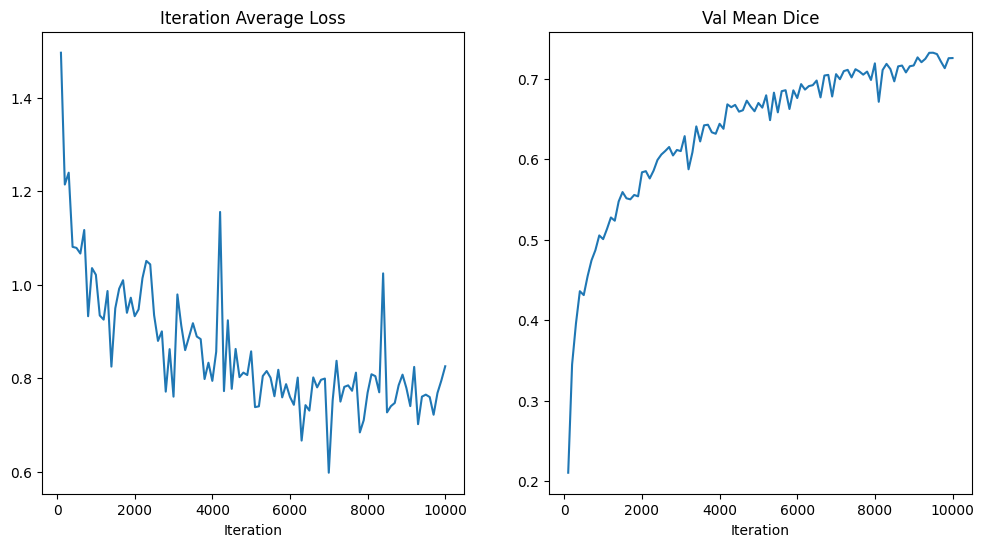

In [22]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.savefig(f'training_plot_{model_name}.png', dpi=300, bbox_inches='tight')
plt.show()

### Check best model output with the input image and label

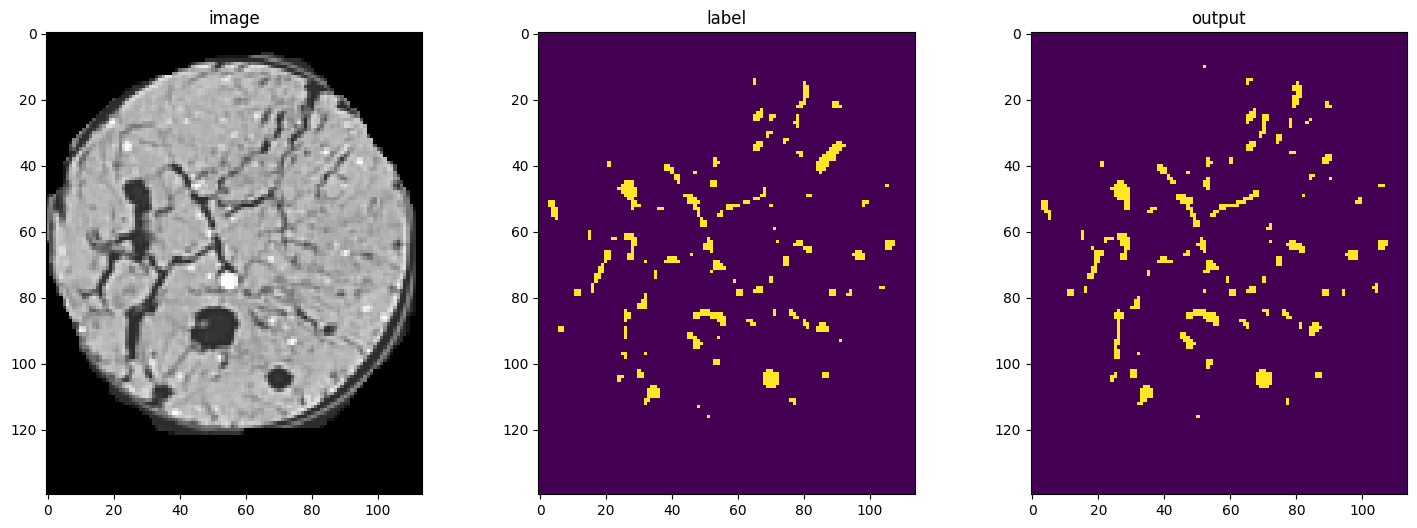

In [23]:
# threshold = torch.nn.Threshold(0.0, 0.0, inplace=False)
case_num = 1
slice = 5
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model" + model_name + ".pth")))
model.eval()
with torch.no_grad():
    img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
    img = val_ds[case_num]["image"]
    label = val_ds[case_num]["label"]
    val_inputs = torch.unsqueeze(img, 1).cuda()
    val_labels = torch.unsqueeze(label, 1).cuda()
    val_outputs = sliding_window_inference(val_inputs, (96, 96, 16), 4, model, overlap=0.8)
    # val_outputs = threshold(val_outputs)
    val_outputs = post_pred(val_outputs)
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title("image")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, slice], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title("label")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, slice])
    plt.subplot(1, 3, 3)
    plt.title("output")
    plt.imshow(val_outputs.detach().cpu().numpy()[0, 0, :, :, slice])
    # plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, slice_map[img_name]])
    plt.show()

In [24]:
# threshold = torch.nn.Threshold(0.0, 0.0, inplace=False)
case_num = 1
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model" + model_name + ".pth")))
model.eval()
with torch.no_grad():
    img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
    img = test_ds[case_num]["image"]
    test_inputs = torch.unsqueeze(img, 1).cuda()
    test_outputs = sliding_window_inference(test_inputs, (96, 96, 16), 4, model, overlap=0.8)

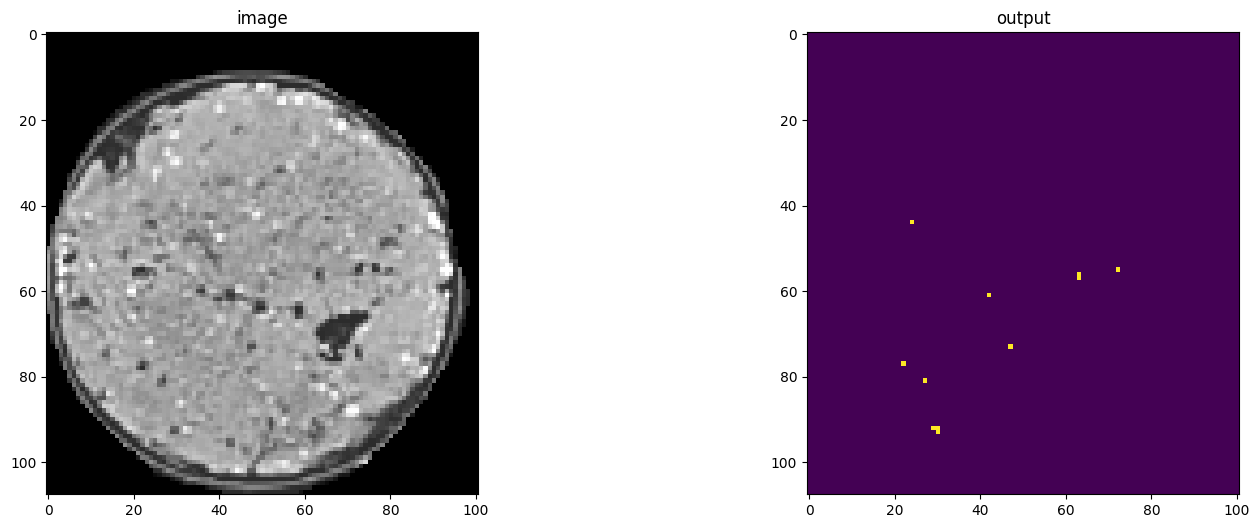

In [25]:
# threshold = torch.nn.Threshold(0.0, 0.0, inplace=False)
slice = 3
threshold = AsDiscrete(threshold=0.5)
with torch.no_grad():
    test_outputs_th = threshold(test_outputs)
    # test_outputs_th = test_outputs.clone()
    plt.figure("check", (18, 6))
    plt.subplot(1, 2, 1)
    plt.title("image")
    plt.imshow(test_inputs.cpu().numpy()[0, 0, :, :, slice], cmap="gray")
    plt.subplot(1, 2, 2)
    plt.title("output")
    plt.imshow(test_outputs_th.detach().cpu().numpy()[0, 0, :, :, slice])
    # plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, slice_map[img_name]])
    plt.show()

In [26]:
test_outputs_th.min(), test_outputs_th.max() 

(metatensor(0., device='cuda:0'), metatensor(1., device='cuda:0'))

### Cleanup data directory

Remove directory if a temporary was used.

In [27]:
# if directory is None:
#     shutil.rmtree(root_dir)